In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
sns.set()

os.chdir('../..')

DATA = Path('data')
RAW  = DATA/'raw'
PROCESSED = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)

In [3]:
proc_train = pd.read_feather(PROCESSED/'proc_train.feather')
proc_val = pd.read_feather(PROCESSED/'proc_val.feather')
proc_all = pd.read_feather(PROCESSED/'proc_all.feather')
proc_test = pd.read_feather(PROCESSED/'proc_test.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [69]:
%%time
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
train_session = pd.read_csv('data/raw/train_session.csv') 
train_tracking = pd.read_csv('data/raw/train_tracking.csv')
productid_category = pd.read_csv('data/raw/productid_category.csv')

CPU times: user 57.4 s, sys: 4.14 s, total: 1min 1s
Wall time: 1min 1s


## Get sequences

In [71]:
all_tracking = pd.concat([train_tracking, test_tracking])

In [72]:
all_tracking.shape

(2263328, 31)

In [89]:
event_labels = {event: idx + 1 for idx, event in enumerate(all_tracking.type.unique())}

In [90]:
all_tracking['type_id'] = all_tracking.type.map(event_labels)

In [91]:
%%time
events_seq = all_tracking.groupby('sid')['type_id'].apply(list)

CPU times: user 11 s, sys: 75.4 ms, total: 11 s
Wall time: 11 s


In [92]:
events_seq.head()

sid
+++elmtsXqN289wWNi6auO1Fm7gyPkXmsKngig88cIqXDDlbW1XjYQ2lChpudqGX              [2, 3, 3, 3, 3, 5, 1, 3, 3, 3, 3, 3, 3]
++0tYP9PmT6jX9O1WjUhWd7w3hWV6xSRMBOdA7HMoBukKsXCbSII2Ryt9Jb259+X                                      [1, 1, 1, 1, 1]
++2CIH+Rnf2MBamibl+EPSMDTKmweZzRgeX/VDBussbBR8c9Yhop7+C2diacJXNE                                         [3, 5, 5, 3]
++3a8LhdXKrKZJeNiBtuHj8znGF/eQADRi0GSnPSlqRajqvP5hVRmmRaJXqbdjsM    [3, 3, 5, 4, 1, 4, 1, 5, 3, 3, 3, 3, 3, 3, 3, ...
++3dzXAmTuAQr+0il3jYZzqk8eoPk6TiffxCqNdQAKyBGp5bu/Hglr99EIB6uq9W                               [3, 3, 5, 1, 1, 10, 1]
Name: type_id, dtype: object

In [155]:
MAX_LEN = 30
def pad_seq(x):
    res = np.zeros(MAX_LEN).astype(int)
    res[max(0, MAX_LEN - len(x)):] = x[-MAX_LEN:]
    return res

In [156]:
events_fixed_seq = events_seq.apply(pad_seq)

In [157]:
events_fixed_seq.head()

sid
+++elmtsXqN289wWNi6auO1Fm7gyPkXmsKngig88cIqXDDlbW1XjYQ2lChpudqGX    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
++0tYP9PmT6jX9O1WjUhWd7w3hWV6xSRMBOdA7HMoBukKsXCbSII2Ryt9Jb259+X    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
++2CIH+Rnf2MBamibl+EPSMDTKmweZzRgeX/VDBussbBR8c9Yhop7+C2diacJXNE    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
++3a8LhdXKrKZJeNiBtuHj8znGF/eQADRi0GSnPSlqRajqvP5hVRmmRaJXqbdjsM    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 5, ...
++3dzXAmTuAQr+0il3jYZzqk8eoPk6TiffxCqNdQAKyBGp5bu/Hglr99EIB6uq9W    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: type_id, dtype: object

In [423]:
duration_seqs_train = np.load(PROCESSED/'f_duration_train.npy')
duration_seqs_test = np.load(PROCESSED/'f_duration_test.npy')
with open(PROCESSED/'f_sessionsmap_train.pkl', 'rb') as f:
    duration_seqs_train_dict = pickle.load(f) 
with open(PROCESSED/'f_sessionsmap_test.pkl', 'rb') as f:
    duration_seqs_test_dict = pickle.load(f) 
    
action_seqs_train = np.load(PROCESSED/'f_actions_train.npy')
action_seqs_test = np.load(PROCESSED/'f_actions_test.npy')

quantity_seqs_train = np.load(PROCESSED/'f_quantity_train.npy')
quantity_seqs_test = np.load(PROCESSED/'f_quantity_test.npy')

## Read metadata

In [424]:
proc_train = pd.read_feather(PROCESSED/'proc_train.feather')
proc_val = pd.read_feather(PROCESSED/'proc_val.feather')
proc_all = pd.read_feather(PROCESSED/'proc_all.feather')
proc_test = pd.read_feather(PROCESSED/'proc_test.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [425]:
train_ids = set(proc_train.sid)
val_ids = set(proc_val.sid)

In [426]:
train_cat_seqs = events_fixed_seq[list(proc_train.sid)]
val_cat_seqs = events_fixed_seq[list(proc_val.sid)]

In [427]:
train_cat_seqs = np.stack(train_cat_seqs).reshape((-1, MAX_LEN, 1))
val_cat_seqs = np.stack(val_cat_seqs).reshape((-1, MAX_LEN, 1))

In [428]:
duration_seqs_train.shape

(133123, 30, 2)

In [429]:
action_seqs_train.shape

(133123, 30, 3)

In [430]:
quantity_seqs_train.shape

(133123, 30, 1)

In [431]:
train_cont_seqs = np.concatenate([
    duration_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_train.sid]],
    action_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_train.sid]],
    quantity_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_train.sid]]
], axis=2)
val_cont_seqs = np.concatenate([
    duration_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_val.sid]],
    action_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_val.sid]],
    quantity_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_val.sid]]
], axis=2)

In [432]:
train_cont_seqs.shape, val_cont_seqs.shape

((79873, 30, 6), (53250, 30, 6))

In [433]:
cat_cols = ['device', 'siteid']
target_col = 'target'
id_col = 'sid'
cont_cols = [x for x in proc_train.columns if x not in cat_cols + [target_col, id_col]]

In [434]:
from src.utils_r import to_cat_codes, apply_cats
to_cat_codes(proc_train, cat_cols)
apply_cats(proc_val, proc_train)
for df in [proc_train, proc_val]:
    for col in cat_cols:
        df[col] = df[col].cat.codes

In [435]:
proc_train['device'] = proc_train.device + 1
proc_val['device'] = proc_val.device + 1

## Standard Scaling

In [436]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([proc_train[cont_cols], proc_val[cont_cols]]))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [437]:
proc_train_cont_norm = scaler.transform(proc_train[cont_cols])
proc_val_cont_norm = scaler.transform(proc_val[cont_cols])

In [438]:
for i, col in enumerate(cont_cols):
    proc_train[col] = proc_train_cont_norm[:, i]
    proc_val[col] = proc_val_cont_norm[:, i]

In [439]:
# DONE: normalize duration, rh and rw

In [440]:
from src.utils_r import MultimodalDataset
from torch.utils.data import DataLoader
ds_trn = MultimodalDataset(proc_train[cat_cols], proc_train[cont_cols],
                           train_cat_seqs, train_cont_seqs, proc_train[target_col])
ds_val = MultimodalDataset(proc_val[cat_cols], proc_val[cont_cols],
                           val_cat_seqs, val_cont_seqs, proc_val[target_col])

In [441]:
dl_trn = DataLoader(ds_trn, batch_size=128, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=128)

In [450]:
from src.utils_r import MultimodalNet

In [451]:
cat_szs = [int(proc_train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(20, (c+1)//2)) for c in cat_szs]

n_cont = len(cont_cols)
emb_drop = 0.3
szs = [400, 200]
drops = [0.1, 0.1]

rnn_hidden_sz = 64
rnn_cont_sz = int(train_cont_seqs.shape[2])

rnn_cat_szs = [int(train_cat_seqs[:,:,0].max()+1)]
rnn_emb_szs = [(c, min(20, (c+1)//2)) for c in rnn_cat_szs]

rnn_n_layers = 2
rnn_drop = 0.2
lin_sz = 10
drop = 0.3
out_sz = 1

In [452]:
emb_szs, rnn_emb_szs, rnn_cont_sz

([(4, 2), (3, 2)], [(22, 11)], 6)

In [453]:
from src.utils_r import train_model
from torch import optim
import torch.nn as nn

In [454]:
USE_CUDA = True

In [456]:
model = MultimodalNet(emb_szs, n_cont, emb_drop, szs, drops, 
                      rnn_hidden_sz, rnn_cont_sz, rnn_emb_szs, 
                      rnn_n_layers, rnn_drop, lin_sz, drop, out_sz)
if USE_CUDA: model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [457]:
%%time
best_epoch = train_model(model, dl_trn, dl_val, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/79873 (16%)]	Loss: 0.777043
Train Epoch: 1 [25600/79873 (32%)]	Loss: 0.688602
Train Epoch: 1 [38400/79873 (48%)]	Loss: 0.627037
Train Epoch: 1 [51200/79873 (64%)]	Loss: 0.575600
Train Epoch: 1 [64000/79873 (80%)]	Loss: 0.519032
Train Epoch: 1 [76800/79873 (96%)]	Loss: 0.469618
Epoch: 1 | Train Logloss: 0.413192 | Val Logloss: 0.416137
Train Epoch: 2 [12800/79873 (16%)]	Loss: 0.423960
Train Epoch: 2 [25600/79873 (32%)]	Loss: 0.390985
Train Epoch: 2 [38400/79873 (48%)]	Loss: 0.358696
Train Epoch: 2 [51200/79873 (64%)]	Loss: 0.338955
Train Epoch: 2 [64000/79873 (80%)]	Loss: 0.330853
Train Epoch: 2 [76800/79873 (96%)]	Loss: 0.317385
Epoch: 2 | Train Logloss: 0.295625 | Val Logloss: 0.300249
Train Epoch: 3 [12800/79873 (16%)]	Loss: 0.304431
Train Epoch: 3 [25600/79873 (32%)]	Loss: 0.298639
Train Epoch: 3 [38400/79873 (48%)]	Loss: 0.292550
Train Epoch: 3 [51200/79873 (64%)]	Loss: 0.295712
Train Epoch: 3 [64000/79873 (80%)]	Loss: 0.296532
Train Epoch: 3 [76800/79873 (96%

In [458]:
%%time
best_epoch = train_model(model, dl_trn, dl_val, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/79873 (16%)]	Loss: 0.274260
Train Epoch: 1 [25600/79873 (32%)]	Loss: 0.276352
Train Epoch: 1 [38400/79873 (48%)]	Loss: 0.264768
Train Epoch: 1 [51200/79873 (64%)]	Loss: 0.273714
Train Epoch: 1 [64000/79873 (80%)]	Loss: 0.272858
Train Epoch: 1 [76800/79873 (96%)]	Loss: 0.278655
Epoch: 1 | Train Logloss: 0.264688 | Val Logloss: 0.274732
Train Epoch: 2 [12800/79873 (16%)]	Loss: 0.276613
Train Epoch: 2 [25600/79873 (32%)]	Loss: 0.286533
Train Epoch: 2 [38400/79873 (48%)]	Loss: 0.265096
Train Epoch: 2 [51200/79873 (64%)]	Loss: 0.266825
Train Epoch: 2 [64000/79873 (80%)]	Loss: 0.272577
Train Epoch: 2 [76800/79873 (96%)]	Loss: 0.273973
Epoch: 2 | Train Logloss: 0.266129 | Val Logloss: 0.276498
Train Epoch: 3 [12800/79873 (16%)]	Loss: 0.276578
Train Epoch: 3 [25600/79873 (32%)]	Loss: 0.273412
Train Epoch: 3 [38400/79873 (48%)]	Loss: 0.268947
Train Epoch: 3 [51200/79873 (64%)]	Loss: 0.272426
Train Epoch: 3 [64000/79873 (80%)]	Loss: 0.273183
Train Epoch: 3 [76800/79873 (96%

In [448]:
%%time
best_epoch = train_model(model, dl_trn, dl_val, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/79873 (16%)]	Loss: 0.471803
Train Epoch: 1 [25600/79873 (32%)]	Loss: 0.278739
Train Epoch: 1 [38400/79873 (48%)]	Loss: 0.275405
Train Epoch: 1 [51200/79873 (64%)]	Loss: 0.274110
Train Epoch: 1 [64000/79873 (80%)]	Loss: 0.274184
Train Epoch: 1 [76800/79873 (96%)]	Loss: 0.274947
Epoch: 1 | Train Logloss: 0.277655 | Val Logloss: 0.284134
Train Epoch: 2 [12800/79873 (16%)]	Loss: 0.275872
Train Epoch: 2 [25600/79873 (32%)]	Loss: 0.271274
Train Epoch: 2 [38400/79873 (48%)]	Loss: 0.275550
Train Epoch: 2 [51200/79873 (64%)]	Loss: 0.270100
Train Epoch: 2 [64000/79873 (80%)]	Loss: 0.265433
Train Epoch: 2 [76800/79873 (96%)]	Loss: 0.272954
Epoch: 2 | Train Logloss: 0.269742 | Val Logloss: 0.277761
Train Epoch: 3 [12800/79873 (16%)]	Loss: 0.280461
Train Epoch: 3 [25600/79873 (32%)]	Loss: 0.264900
Train Epoch: 3 [38400/79873 (48%)]	Loss: 0.267394
Train Epoch: 3 [51200/79873 (64%)]	Loss: 0.261557
Train Epoch: 3 [64000/79873 (80%)]	Loss: 0.280019
Train Epoch: 3 [76800/79873 (96%

In [301]:
%%time
best_epoch = train_model(model, dl_trn, dl_val, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/79873 (16%)]	Loss: 0.546910
Train Epoch: 1 [25600/79873 (32%)]	Loss: 0.290007
Train Epoch: 1 [38400/79873 (48%)]	Loss: 0.277609
Train Epoch: 1 [51200/79873 (64%)]	Loss: 0.267862
Train Epoch: 1 [64000/79873 (80%)]	Loss: 0.273598
Train Epoch: 1 [76800/79873 (96%)]	Loss: 0.276280
Epoch: 1 | Train Logloss: 0.272865 | Val Logloss: 0.280519
Train Epoch: 2 [12800/79873 (16%)]	Loss: 0.282214
Train Epoch: 2 [25600/79873 (32%)]	Loss: 0.267516
Train Epoch: 2 [38400/79873 (48%)]	Loss: 0.265958
Train Epoch: 2 [51200/79873 (64%)]	Loss: 0.267439
Train Epoch: 2 [64000/79873 (80%)]	Loss: 0.274113
Train Epoch: 2 [76800/79873 (96%)]	Loss: 0.268026
Epoch: 2 | Train Logloss: 0.268752 | Val Logloss: 0.277009
Train Epoch: 3 [12800/79873 (16%)]	Loss: 0.271666
Train Epoch: 3 [25600/79873 (32%)]	Loss: 0.265220
Train Epoch: 3 [38400/79873 (48%)]	Loss: 0.266653
Train Epoch: 3 [51200/79873 (64%)]	Loss: 0.266028
Train Epoch: 3 [64000/79873 (80%)]	Loss: 0.274680
Train Epoch: 3 [76800/79873 (96%

## Test

In [331]:
proc_train = pd.read_feather(PROCESSED/'proc_train.feather')
proc_val = pd.read_feather(PROCESSED/'proc_val.feather')
proc_all = pd.read_feather(PROCESSED/'proc_all.feather')
proc_test = pd.read_feather(PROCESSED/'proc_test.feather')

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [332]:
MAX_LEN = 30

In [333]:
train_ids = set(proc_all.sid)
test_ids = set(proc_test.sid)

In [334]:
train_cat_seqs = events_fixed_seq[list(proc_all.sid)]
test_cat_seqs = events_fixed_seq[list(proc_test.sid)]

In [335]:
train_cat_seqs = np.stack(train_cat_seqs).reshape((-1, MAX_LEN, 1))
test_cat_seqs = np.stack(test_cat_seqs).reshape((-1, MAX_LEN, 1))

In [336]:
train_cont_seqs = duration_seqs_train[[duration_seqs_train_dict[sid] for sid in proc_all.sid]]
test_cont_seqs = duration_seqs_test[[duration_seqs_test_dict[sid] for sid in proc_test.sid]]

In [337]:
cat_cols = ['device', 'siteid']
target_col = 'target'
id_col = 'sid'
cont_cols = [x for x in proc_all.columns if x not in cat_cols + [target_col, id_col]]

In [338]:
from src.utils_r import to_cat_codes, apply_cats
to_cat_codes(proc_all, cat_cols)
apply_cats(proc_test, proc_all)
for df in [proc_all, proc_test]:
    for col in cat_cols:
        df[col] = df[col].cat.codes

In [339]:
proc_all['device'] = proc_all.device + 1
proc_test['device'] = proc_test.device + 1

## Standard Scaling

In [342]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([proc_all[cont_cols], proc_test[cont_cols]]))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [343]:
proc_train_cont_norm = scaler.transform(proc_all[cont_cols])
proc_test_cont_norm = scaler.transform(proc_test[cont_cols])

In [344]:
for i, col in enumerate(cont_cols):
    proc_all[col] = proc_train_cont_norm[:, i]
    proc_test[col] = proc_test_cont_norm[:, i]

In [349]:
from src.utils_r import MultimodalDataset
from torch.utils.data import DataLoader
ds_trn = MultimodalDataset(proc_all[cat_cols], proc_all[cont_cols],
                           train_cat_seqs, train_cont_seqs, proc_all[target_col])
ds_tst = MultimodalDataset(proc_test[cat_cols], proc_test[cont_cols],
                           test_cat_seqs, test_cont_seqs, proc_test[target_col])

In [350]:
dl_trn = DataLoader(ds_trn, batch_size=128, shuffle=True)
dl_tst = DataLoader(ds_tst, batch_size=128)

In [351]:
from src.utils_r import MultimodalNet

In [379]:
cat_szs = [int(proc_all[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(20, (c+1)//2)) for c in cat_szs]

n_cont = len(cont_cols)
emb_drop = 0.3
szs = [600, 300]
drops = [0.3, 0.3]

rnn_hidden_sz = 128
rnn_cont_sz = int(train_cont_seqs.shape[2])

rnn_cat_szs = [int(train_cat_seqs[:,:,0].max()+1)]
rnn_emb_szs = [(c, min(20, (c+1)//2)) for c in rnn_cat_szs]

rnn_n_layers = 2
rnn_drop = 0.2
rnn_out_sz = 1

In [380]:
from src.utils_r import train_model
from torch import optim
import torch.nn as nn

In [381]:
USE_CUDA = True

In [382]:
model = MultimodalNet(emb_szs, n_cont, emb_drop, szs, drops, 
                      rnn_hidden_sz, rnn_cont_sz, rnn_emb_szs, 
                      rnn_n_layers, rnn_drop, rnn_out_sz)
if USE_CUDA: model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [383]:
%%time
best_epoch = train_model(model, dl_trn, None, optimizer, criterion, 
                         n_epochs=10, print_every=100, USE_CUDA=USE_CUDA)

Train Epoch: 1 [12800/133123 (10%)]	Loss: 0.372044
Train Epoch: 1 [25600/133123 (19%)]	Loss: 0.277064
Train Epoch: 1 [38400/133123 (29%)]	Loss: 0.280491
Train Epoch: 1 [51200/133123 (38%)]	Loss: 0.276768
Train Epoch: 1 [64000/133123 (48%)]	Loss: 0.279410
Train Epoch: 1 [76800/133123 (58%)]	Loss: 0.275738
Train Epoch: 1 [89600/133123 (67%)]	Loss: 0.270645
Train Epoch: 1 [102400/133123 (77%)]	Loss: 0.278478
Train Epoch: 1 [115200/133123 (86%)]	Loss: 0.277175
Train Epoch: 1 [128000/133123 (96%)]	Loss: 0.275394
Epoch: 1 | Train Logloss: 0.275588
Train Epoch: 2 [12800/133123 (10%)]	Loss: 0.269491
Train Epoch: 2 [25600/133123 (19%)]	Loss: 0.281111
Train Epoch: 2 [38400/133123 (29%)]	Loss: 0.277274
Train Epoch: 2 [51200/133123 (38%)]	Loss: 0.276395
Train Epoch: 2 [64000/133123 (48%)]	Loss: 0.271067
Train Epoch: 2 [76800/133123 (58%)]	Loss: 0.273445
Train Epoch: 2 [89600/133123 (67%)]	Loss: 0.269216
Train Epoch: 2 [102400/133123 (77%)]	Loss: 0.273017
Train Epoch: 2 [115200/133123 (86%)]	Loss: 

In [384]:
%%time
from src.utils_r import eval_model
test_targets, test_preds = eval_model(model, dl_tst, USE_CUDA=True)

CPU times: user 5.14 s, sys: 673 ms, total: 5.82 s
Wall time: 5.82 s


In [385]:
proc_test[target_col] = test_preds

In [386]:
proc_test[target_col].describe()

count    88750.000000
mean         0.082013
std          0.092036
min          0.002770
25%          0.031347
50%          0.049635
75%          0.085779
max          0.992202
Name: target, dtype: float64

In [366]:
proc_test[target_col].describe()

count    88750.000000
mean         0.087562
std          0.089772
min          0.000000
25%          0.034235
50%          0.052727
75%          0.096598
max          0.999556
Name: target, dtype: float64

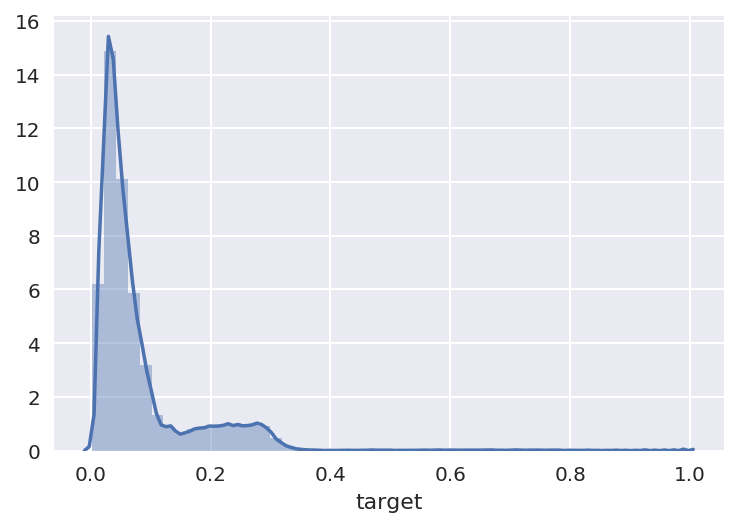

In [387]:
sns.distplot(proc_test[target_col])

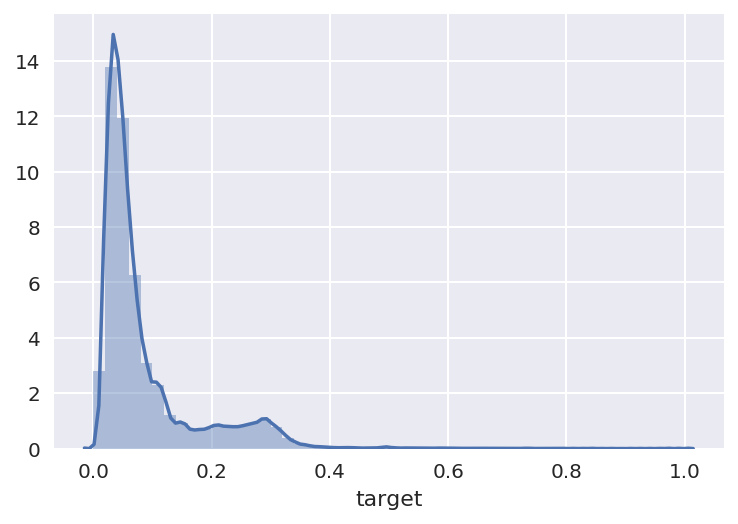

In [367]:
sns.distplot(proc_test[target_col])

In [368]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_2_submit.csv', index=False)

In [369]:
sub1 = pd.read_csv(SUBMISSIONS/'robert_1_submit.csv')

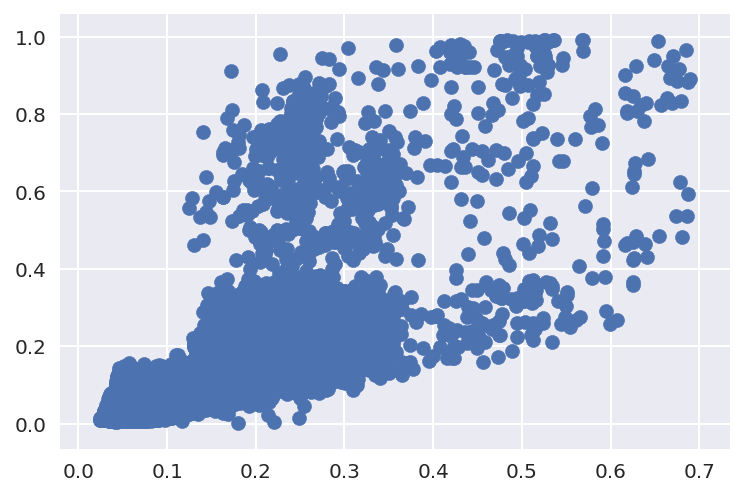

In [388]:
plt.scatter(sub1[target_col], proc_test[target_col])

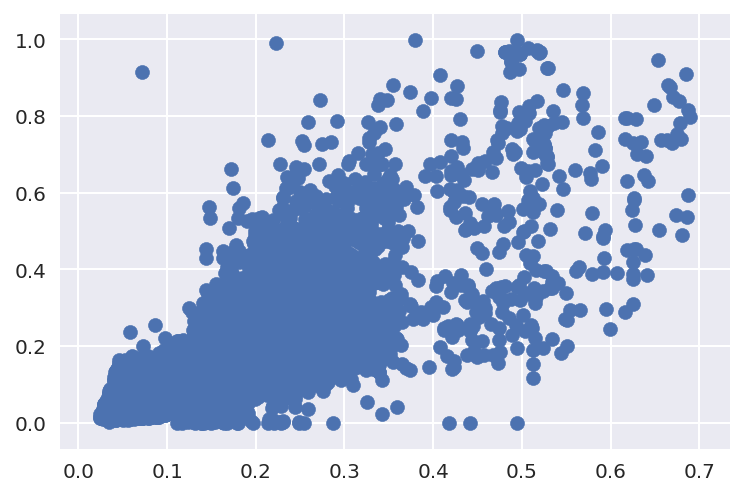

In [371]:
plt.scatter(sub1[target_col], proc_test[target_col])

In [372]:
sub1[target_col].corr(proc_test[target_col])

0.8803821323305331

## Blending

In [373]:
sub2 = pd.read_csv(SUBMISSIONS/'robert_2_submit.csv')

In [374]:
proc_test[target_col] = sub1[target_col] * 0.6 + sub2[target_col] * 0.4

In [376]:
proc_test[target_col].describe()

count    88750.000000
mean         0.093601
std          0.076235
min          0.019424
25%          0.047814
50%          0.064307
75%          0.093536
max          0.774890
Name: target, dtype: float64

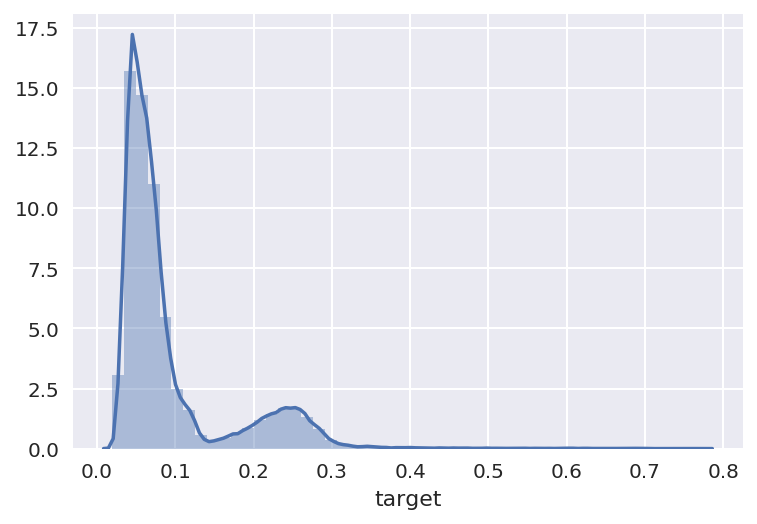

In [377]:
sns.distplot(proc_test[target_col])

In [378]:
proc_test[[id_col, target_col]].to_csv(SUBMISSIONS/'robert_3_submit.csv', index=False)

In [27]:
import pickle
with open(DATA/'neuralnet/tracking_events_dict.pickle', 'rb') as f:
    tracking_events_dict = pickle.load(f)

In [32]:
tracking_events = np.load(DATA/'neuralnet/tracking_events.npy')
tracking_events_norm = np.load(DATA/'neuralnet/tracking_events_norm.npy')
tracking_movements   = np.load(DATA/'neuralnet/tracking_movements.npy')

In [29]:
tracking_events_norm.shape

(133123, 100, 12)

In [64]:
a = np.random.randint(0, 100, (4, 5, 6)).astype(float)
a_flat = np.reshape(a, (-1, 1))
a_flat.shape

(120, 1)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(a_flat)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [66]:
b = np.random.randint(0, 100, (6, 2, 10)).astype(float)
b_flat = np.reshape(b, (-1, 1))
b_flat_norm = scaler.transform(b_flat)
b_norm = np.reshape(b_norm, b.shape)

In [67]:
b_norm

array([[[-0.43584675,  1.10449517, -1.17100993,  0.61438638,
          1.17451071, -1.4510721 , -0.68090114,  0.54437084,
         -0.75091668,  1.69962727],
        [-1.17100993,  1.6646195 ,  0.64939415,  1.34954956,
          0.43934752, -0.75091668, -0.82093222, -1.13600216,
          1.83965835, -1.13600216]],

       [[-1.17100993,  1.62961173,  1.76964281,  0.26430867,
          1.10449517, -1.2060177 , -1.4510721 , -0.47085452,
         -0.78592445, -0.15578458],
        [-1.06598662,  0.71940969, -0.08576904, -0.71590891,
          1.17451071,  1.83965835, -0.47085452, -1.55609541,
         -0.43584675, -1.13600216]],

       [[-1.34604879, -0.40083898,  1.76964281, -1.03097885,
          0.05426204, -0.12077681, -0.47085452, -1.06598662,
          0.71940969,  1.34954956],
        [-0.54087006, -0.15578458,  0.92945631,  0.68440192,
         -0.0157535 , -0.68090114,  1.17451071, -0.22580012,
         -1.48607987, -0.19079235]],

       [[ 0.85944077, -1.34604879, -0.40083898

In [40]:
tracking_events[180,:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
tracking_movements.shape

(133123, 100, 2)